In [1]:
import pandas as pd
import numpy as np
import json

from IPython.display import Markdown as md
from IPython.display import HTML, display
from collections import Counter
import math

%matplotlib inline

pd.options.display.float_format = '{:.0f}'.format

In [2]:
df = pd.read_csv('../output/input_descriptives.csv')

#population size
num_patients = len(df['patient_id'].unique())
print(f'Population size (Attended A&E and/or had any cause hospitalisation): {num_patients}')



Population size (Attended A&E and/or had any cause hospitalisation): 10000


Number of hospital admissions

In [3]:
# Number of hospital admissions

num_patients_hosp = len(df[df['hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_emergency = len(df[df['emergency_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_prim_covid = len(df[df['primary_covid_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_emergency_prim_covid = len(df[df['emergency_primary_covid_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_covid = len(df[df['covid_hospital_admission'].notna()]['patient_id'].unique())
num_patients_hosp_emergency_covid = len(df[df['emergency_covid_hospital_admission'].notna()]['patient_id'].unique())

emergency_hospitalisation_dict = {
    "hospital_admission": num_patients_hosp,
    "emergency_hospital_admission": num_patients_hosp_emergency,
    "admisssion_primary_covid": num_patients_hosp_prim_covid,
    "admission_secondary_covid": num_patients_hosp_covid,
    "emergency_admission_primary_covid": num_patients_hosp_emergency_prim_covid,
    "emergency_admission_secondary_covid": num_patients_hosp_emergency_covid,
}

pd.DataFrame.from_dict(emergency_hospitalisation_dict, orient='index')

,0
hospital_admission,3000
emergency_hospital_admission,3000
admisssion_primary_covid,3000
admission_secondary_covid,3000
emergency_admission_primary_covid,3000
emergency_admission_secondary_covid,3000


Total Number of A&E Attendances

In [4]:
# A&E attendance

# a&e attendance all
num_patients_attended_ae = len(df[(df['all_ae_attendance_any_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_discharge = len(df[(df['all_ae_attendance_with_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_hosp_discharge = len(df[(df['all_ae_attendance_hosp_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_cov = len(df[(df['all_ae_attendance_covid_status']==1)]['patient_id'].unique())
num_patients_attended_ae_resp = len(df[(df['all_ae_attendance_respiratory_status']==1)]['patient_id'].unique())
num_patients_attended_ae_cov_pc = len(df[(df['all_covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_suspected_cov_pc = len(df[(df['all_suspected_covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test = len(df[(df['all_positive_covid_test_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test_month = len(df[(df['all_positive_covid_test_month_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_high_risk = len(df[(df['hospital_admission'].notna()) & (df['all_ae_attendance_any_discharge']==1) & (df['risk_group']==3)]['patient_id'].unique())
num_patients_attended_ae_medium_risk = len(df[(df['hospital_admission'].notna()) & (df['all_ae_attendance_any_discharge']==1) & (df['risk_group']==3)]['patient_id'].unique())
num_patients_attended_ae_low_risk = len(df[(df['hospital_admission'].notna()) & (df['all_ae_attendance_any_discharge']==1) & (df['risk_group']==1)]['patient_id'].unique())


all_ae_dict = {
    "attended_ae": num_patients_attended_ae,
    "attended_ae_with_discharge": num_patients_attended_ae_with_discharge,
    "attended_ae_hosp_discharge": num_patients_attended_ae_with_hosp_discharge,
    "attended_ae_cov": num_patients_attended_ae_cov,
    "attended_ae_resp": num_patients_attended_ae_resp,
    "attended_ae_cov_pc": num_patients_attended_ae_cov_pc,
    "attended_ae_suspected_cov_pc": num_patients_attended_ae_suspected_cov_pc,
    "attended_ae_pos_test": num_patients_attended_ae_pos_test,
    "attended_ae_pos_test_month": num_patients_attended_ae_pos_test_month,
    "attended_ae_high_risk": num_patients_attended_ae_high_risk,
    "attended_ae_medium_risk": num_patients_attended_ae_medium_risk,
    "attended_ae_low_risk": num_patients_attended_ae_low_risk,
}

pd.DataFrame.from_dict(all_ae_dict, orient='index')

,0
attended_ae,5000
attended_ae_with_discharge,4000
attended_ae_hosp_discharge,4000
attended_ae_cov,9001
attended_ae_resp,9001
attended_ae_cov_pc,5000
attended_ae_suspected_cov_pc,5000
attended_ae_pos_test,5000
attended_ae_pos_test_month,5000
attended_ae_high_risk,0


A&E Attendances in emergency hospitalisations

In [5]:

num_patients_attended_ae = len(df[(df['any_ae_attendance_any_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_discharge = len(df[(df['any_ae_attendance_with_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_hosp_discharge = len(df[(df['any_ae_attendance_hosp_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_cov = len(df[(df['any_ae_attendance_covid_status']==1)]['patient_id'].unique())
num_patients_attended_ae_resp = len(df[(df['any_ae_attendance_respiratory_status']==1)]['patient_id'].unique())
num_patients_attended_ae_cov_pc = len(df[(df['any_covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_suspected_cov_pc = len(df[(df['any_suspected_covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test = len(df[(df['any_positive_covid_test_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test_month = len(df[(df['any_positive_covid_test_month_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_high_risk = len(df[(df['emergency_hospital_admission'].notna()) & (df['any_ae_attendance_any_discharge']==1) & (df['risk_group']==3)]['patient_id'].unique())
num_patients_attended_ae_medium_risk = len(df[(df['emergency_hospital_admission'].notna()) & (df['any_ae_attendance_any_discharge']==1) & (df['risk_group']==2)]['patient_id'].unique())
num_patients_attended_ae_low_risk = len(df[(df['emergency_hospital_admission'].notna()) & (df['any_ae_attendance_any_discharge']==1) & (df['risk_group']==1)]['patient_id'].unique())


all_ae_dict = {
    "attended_ae": num_patients_attended_ae,
    "attended_ae_with_discharge": num_patients_attended_ae_with_discharge,
    "attended_ae_hosp_discharge": num_patients_attended_ae_with_hosp_discharge,
    "attended_ae_cov": num_patients_attended_ae_cov,
    "attended_ae_resp": num_patients_attended_ae_resp,
    "attended_ae_cov_pc": num_patients_attended_ae_cov_pc,
    "attended_ae_suspected_cov_pc": num_patients_attended_ae_suspected_cov_pc,
    "attended_ae_pos_test": num_patients_attended_ae_pos_test,
    "attended_ae_pos_test_month": num_patients_attended_ae_pos_test_month,
    "attended_ae_high_risk": num_patients_attended_ae_high_risk,
    "attended_ae_medium_risk": num_patients_attended_ae_medium_risk,
    "attended_ae_low_risk": num_patients_attended_ae_low_risk,
}

pd.DataFrame.from_dict(all_ae_dict, orient='index')

,0
attended_ae,5000
attended_ae_with_discharge,4000
attended_ae_hosp_discharge,4000
attended_ae_cov,9001
attended_ae_resp,9001
attended_ae_cov_pc,5000
attended_ae_suspected_cov_pc,5000
attended_ae_pos_test,5000
attended_ae_pos_test_month,5000
attended_ae_high_risk,0


A&E attendance in COVID emergency hospitalisations

In [6]:
# a&e attendance all
num_patients_attended_ae = len(df[(df['ae_attendance_any_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_discharge = len(df[(df['ae_attendance_with_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_with_hosp_discharge = len(df[(df['ae_attendance_hosp_discharge']==1)]['patient_id'].unique())
num_patients_attended_ae_cov = len(df[(df['ae_attendance_covid_status']==1)]['patient_id'].unique())
num_patients_attended_ae_resp = len(df[(df['ae_attendance_respiratory_status']==1)]['patient_id'].unique())
num_patients_attended_ae_cov_pc = len(df[(df['covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_suspected_cov_pc = len(df[(df['suspected_covid_primary_care_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test = len(df[(df['positive_covid_test_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_pos_test_month = len(df[(df['positive_covid_test_month_before_ae_attendance']==1)]['patient_id'].unique())
num_patients_attended_ae_high_risk = len(df[(df['emergency_covid_hospital_admission'].notna()) & (df['ae_attendance_any_discharge']==1) & (df['risk_group']==3)]['patient_id'].unique())
num_patients_attended_ae_medium_risk = len(df[(df['emergency_covid_hospital_admission'].notna()) & (df['ae_attendance_any_discharge']==1) & (df['risk_group']==2)]['patient_id'].unique())
num_patients_attended_ae_low_risk = len(df[(df['emergency_covid_hospital_admission'].notna()) & (df['ae_attendance_any_discharge']==1) & (df['risk_group']==1)]['patient_id'].unique())


all_ae_dict = {
    "attended_ae": num_patients_attended_ae,
    "attended_ae_with_discharge": num_patients_attended_ae_with_discharge,
    "attended_ae_hosp_discharge": num_patients_attended_ae_with_hosp_discharge,
    "attended_ae_cov": num_patients_attended_ae_cov,
    "attended_ae_resp": num_patients_attended_ae_resp,
    "attended_ae_cov_pc": num_patients_attended_ae_cov_pc,
    "attended_ae_suspected_cov_pc": num_patients_attended_ae_suspected_cov_pc,
    "attended_ae_pos_test": num_patients_attended_ae_pos_test,
    "attended_ae_pos_test_month": num_patients_attended_ae_pos_test_month,
    "attended_ae_high_risk": num_patients_attended_ae_high_risk,
    "attended_ae_medium_risk": num_patients_attended_ae_medium_risk,
    "attended_ae_low_risk": num_patients_attended_ae_low_risk,
}

pd.DataFrame.from_dict(all_ae_dict, orient='index')

,0
attended_ae,5000
attended_ae_with_discharge,4000
attended_ae_hosp_discharge,4000
attended_ae_cov,9001
attended_ae_resp,9001
attended_ae_cov_pc,5000
attended_ae_suspected_cov_pc,5000
attended_ae_pos_test,5000
attended_ae_pos_test_month,5000
attended_ae_high_risk,0


Discharge destination in those with primary covid in emergency hospital admissions (who went to A&E)

In [7]:
prim_cov_ae_discharge = df[(df['emergency_covid_hospital_admission'].notna() & df['ae_attendance_any_discharge']==1)]['discharge_destination']
missing = prim_cov_ae_discharge.isna().sum()
destination_dict = Counter(prim_cov_ae_discharge[prim_cov_ae_discharge.notnull()])
destination_dict['missing'] = missing

discharge_dict = {1066341000000100:"Ambulatory Emergency Care", 19712007: "Patient Transfer", 183919006: "Hospice", 1066361000000104: "High dependency unit", 305398007: "Mortuary", 1066381000000108: "Special baby care unit", 1066331000000109: "Emergency department short stay ward", 306705005: "Police custody", 306706006:"Ward", 306689006: "Home", 306694006: "Nursing Home", 306691003: "Residential Home", 1066351000000102: "Hospital at home", 1066401000000108: "Neonatal ICU", 1066371000000106: "Coronary Care Unit", 50861005: "Legal Custody", 1066391000000105: "ICU", "missing": "missing"}
percent_dict = {}
data = []
total = 0

other_count=0
drop_keys=[]
#Drop dictionary pairs if value <10
for key, value in destination_dict.items():
    if value <10:
        other_count +=value
        drop_keys.append(key)
        
for key in drop_keys:
    del destination_dict[key]
    
destination_dict["Other"] = other_count

for key, value in destination_dict.items():
    total+=value

for key, value in destination_dict.items():
    if key=="Other":
        percent = (value/total) * 100
        row = ["Other", percent]
        data.append(row)
    else:
        percent = (value/total) * 100
        row = [discharge_dict[key], percent]
        data.append(row)

discharge_destination_df = pd.DataFrame(data, columns=["Discharge Destination", "%"])

In [8]:
discharge_destination_df

,Discharge Destination,%
0,Ward,19
1,ICU,21
2,missing,59
3,Other,0


Predictions

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn import tree

In [54]:
df = pd.read_csv('../output/input.csv')

In [55]:
df_ae_hospital_discharge = df[df['ae_attendance_hosp_discharge']==1]

In [56]:
di = {"low": 1, "medium": 2, "high": 3, "0": np.nan}
df['risk_group'] = df['risk_group'].map(di)    

In [64]:
features = ['ae_attendance_hosp_discharge','risk_group', 'ae_attendance_covid_status', 'ae_attendance_respiratory_status', 'positive_covid_test_before_ae_attendance', 'positive_covid_test_month_before_ae_attendance', 'positive_covid_test_week_before_ae_attendance', 'covid_primary_care_before_ae_attendance', 'suspected_covid_primary_care_before_ae_attendance']
features = ['ae_attendance_hosp_discharge', 'risk_group']
X = df[features]
y = df['emergency_covid_hospital_admission'].notna().astype(int)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [66]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

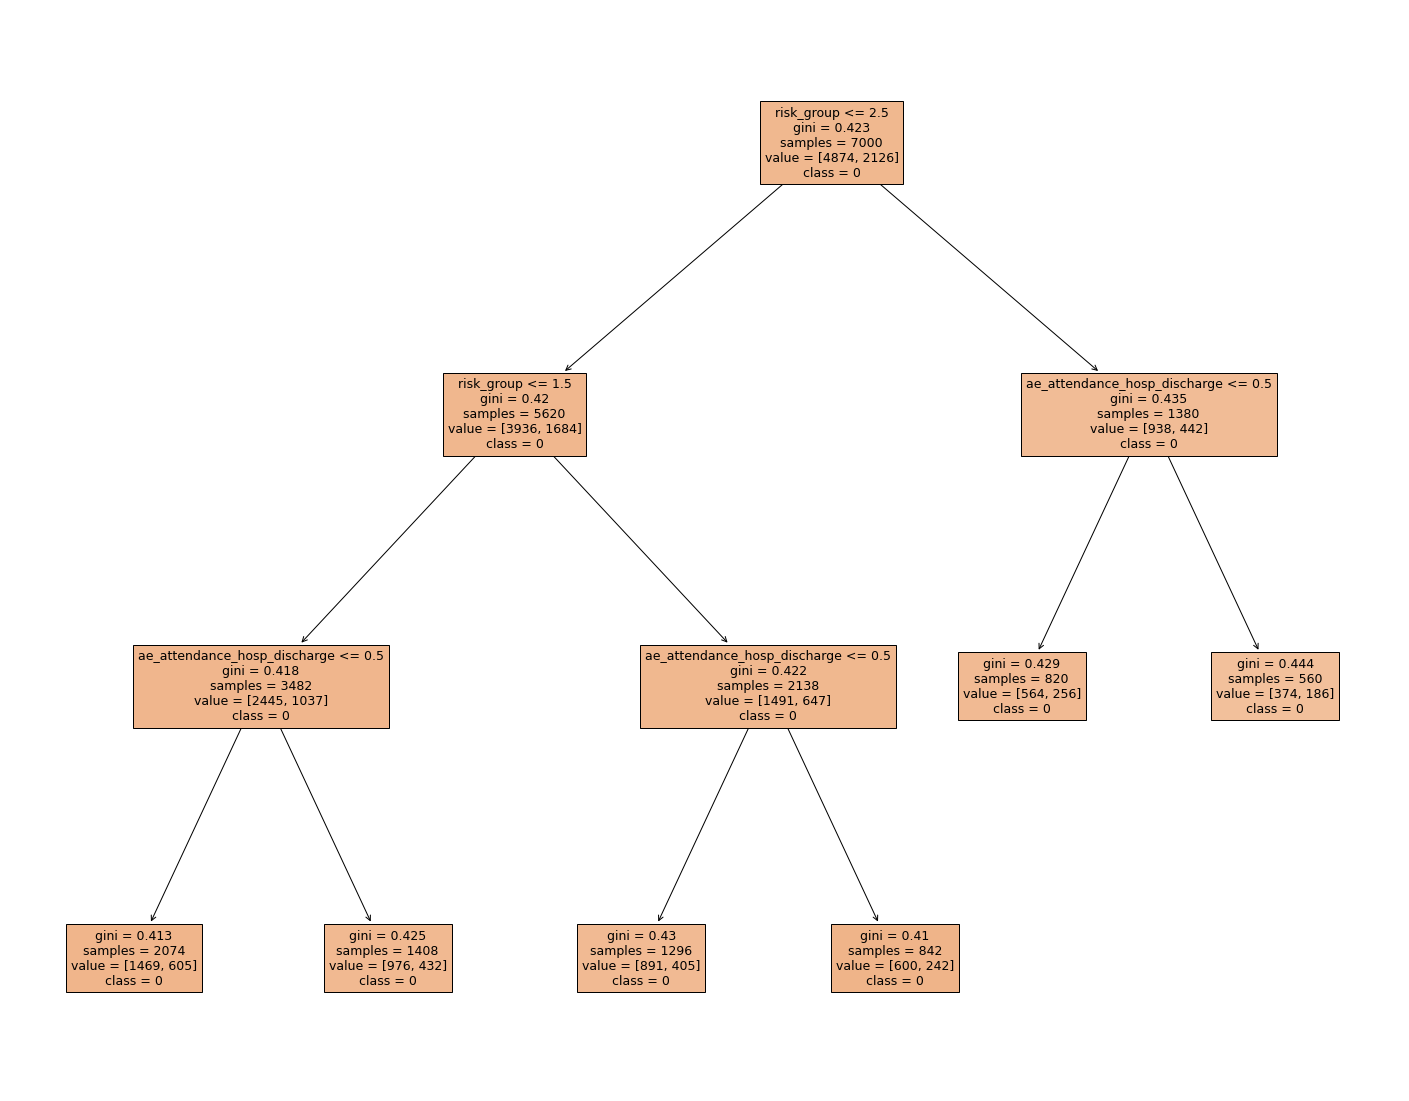

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,  
                   class_names=['0', '1'],
                   filled=True)